## Credit-Risk-part2

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/application_test.csv


## Continuting extracting feature to enhance the score

[Link to part#1 with score of 0.754](https://www.kaggle.com/salmaeng/credit-risk-part-1)

In [2]:
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

I will start by getting the #of client's previous loans using `bureau` and `bureau_balance` data.

* `bureau`: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.

* `bureau_balance`: monthly information about the previous loans. Each month has its own row.

In [3]:
# read in the data into notebook 
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
# groupby client-id, count #previous loans
from pandas import DataFrame

prev_loan_count = bureau.groupby('SK_ID_CURR', as_index = False).count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_count'})

# prev_loan_count = prev_loan_count['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_count'}).head()



In [5]:
prev_loan_count.head()

,SK_ID_CURR,previous_loan_count,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100001,7,7,7,7,7,7,4,0,7,7,7,6,7,7,7,7
1,100002,8,8,8,8,8,6,6,5,8,8,5,4,8,8,8,7
2,100003,4,4,4,4,4,4,3,4,4,4,4,4,4,4,4,0
3,100004,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,0
4,100005,3,3,3,3,3,3,1,1,3,3,3,3,3,3,3,3


In [6]:
# join with the training dataframe
pd.set_option('display.max_column', None)
train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
train = train.merge(prev_loan_count, on = 'SK_ID_CURR', how = 'left')

# fill the missing values with 0

train['previous_loan_count'] = train['previous_loan_count'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_count,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,8.0,8.0,8.0,8.0,6.0,6.0,5.0,8.0,8.0,5.0,4.0,8.0,8.0,8.0,7.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0

In [7]:
train['previous_loan_count'].dtypes

dtype('float64')

It is already there :-)

## Calculating Pearson correlation value.

Investigate the feature importance through the r-value (Pearson correlation), it not a measure of importance for new variables; however, it provide a reference of wheather a varaible will be helpful to the model or not. 

Higher r-value with respect to the dependent variable means any change in that variable would lead to a significant change in the dependent variable. So, in the next step, I would look into the highest absolute value of r-value relative to the dependent variable. 

## KDE
Kernel Density Estimator plot shows the distribution of a single variable relative to the target varaible

In [8]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

I will see the distribution with the `EXT_SOURCE_3` as this is the most important feature in [credit-risk-part-1 kernel](https://www.kaggle.com/salmaeng/credit-risk-part-1)

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


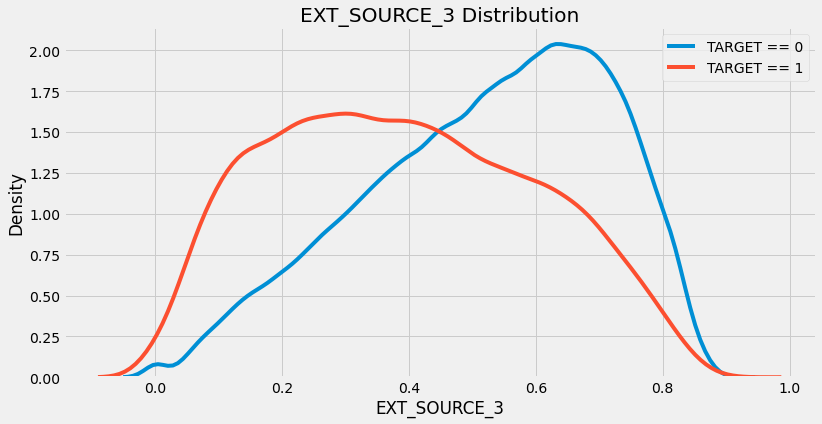

In [9]:
kde_target('EXT_SOURCE_3', train)

It plot the same behaviour as before, so we are good to go and apply it to the `previous_loan_count` variable

The correlation between previous_loan_count and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


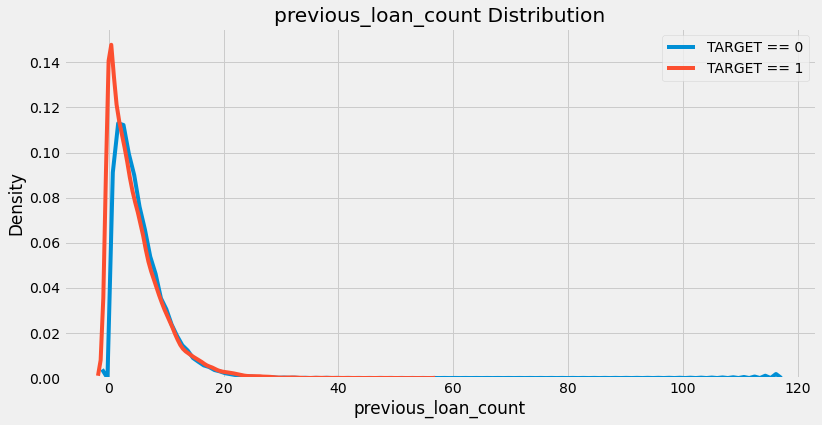

In [10]:
kde_target('previous_loan_count', train)

It's hard to confirm if this variable will be important to the final model. The correlation coefficient is extremely weak and there is almost no significant difference in the distributions.

Let's investigate more variables from the bureau dataframe. I will doing so by getting min, max, avg for numerical variables. 

## Aggregating numeric columns

In [11]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'min','max','sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean   min  max   sum              count   
0     100001           7  -735.000000 -1572  -49 -5145                  7   
1     100002           8  -874.000000 -1437 -103 -6992                  8   
2     100003           4 -1400.750000 -2586 -606 -5603                  4   
3     100004           2  -867.000000 -1326 -408 -1734                  2   
4     100005           3  -190.666667  -373  -62  -572                  3   

                   DAYS_CREDIT_ENDDATE                                      \
  mean min max sum               count        mean     min     max     sum   
0  0.0   0   0   0                   7   82.428571 -1329.0  1778.0   577.0   
1  0.0   0   0   0                   6 -349.000000 -1072.0   780.0 -2094.0   
2  0.0   0   0   0                   4 -544.500000 -2434.0  1216.0 -2178.0   
3  0.0   0   0   0                   2 -488.500000  -595.0  -382.0  -977.0   
4  0.0   0   0   0                   3  439.333333  -128.0  1324.0  1318.0   

  DAYS_ENDDATE_FACT                                      \
              count         mean     min    max     sum   
0                 4  -825.500000 -1328.0 -544.0 -3302.0   
1                 6  -697.500000 -1185.0  -36.0 -4185.0   
2                 3 -1097.333333 -2131.0 -540.0 -3292.0   
3                 2  -532.500000  -683.0 -382.0 -1065.0   
4                 1  -123.000000  -123.0 -123.0  -123.0   

  AMT_CREDIT_MAX_OVERDUE                                     \
                   count      mean  min       max       sum   
0                      0       NaN  NaN       NaN     0.000   
1                      5  1681.029  0.0  5043.645  8405.145   
2                      4     0.000  0.0     0.000     0.000   
3                      1     0.000  0.0     0.000     0.000   
4                      1     0.000  0.0     0.000     0.000   

  CNT_CREDIT_PROLONG                  AMT_CREDIT_SUM                          \
               count mean min max sum          count           mean      min   
0                  7  0.0   0   0   0              7  207623.571429  85500.0   
1                  8  0.0   0   0   0              8  108131.945625      0.0   
2                  4  0.0   0   0   0              4  254350.125000  22248.0   
3                  2  0.0   0   0   0              2   94518.900000  94500.0   
4                  3  0.0   0   0   0              3  219042.000000  29826.0   

                         AMT_CREDIT_SUM_DEBT                                \
        max          sum               count           mean  min       max   
0  378000.0  1453365.000                   7   85240.928571  0.0  373239.0   
1  450000.0   865055.565                   5   49156.200000  0.0  245781.0   
2  810000.0  1017400.500                   4       0.000000  0.0       0.0   
3   94537.8   189037.800                   2       0.000000  0.0       0.0   
4  568800.0   657126.000                   3  189469.500000  0.0  543087.0   

            AMT_CREDIT_SUM_LIMIT                                             \
        sum                count          mean  min         max         sum   
0  596686.5                    6       0.00000  0.0       0.000       0.000   
1  245781.0                    4    7997.14125  0.0   31988.565   31988.565   
2       0.0                    4  202500.00000  0.0  810000.000  810000.000   
3       0.0                    2       0.00000  0.0       0.000       0.000   
4  568408.5                    3       0.00000  0.0       0.000       0.000   

  AMT_CREDIT_SUM_OVERDUE                     DAYS_CREDIT_UPDATE              \
                   count mean  min  max  sum              count        mean   
0                      7  0.0  0.0  0.0  0.0                  7  -93.142857   
1                      8  0.0  0.0  0.0  0.0                  8 -499.875000   
2                      4  0.0  0.0  0.0  0.0                  4 -816.000000   
3 

We need to create new names for each of these columns. The following code makes new names by appending the stat to the name. Here we have to deal with the fact that the dataframe has a multi-level index. I find these confusing and hard to work with, so I try to reduce to a single level index as quickly as possible.

In [12]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [13]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-1572,-49,-5145,7,0.0,0,0,0,7,82.428571,-1329.0,1778.0,577.0,4,-825.500000,-1328.0,-544.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,85500.0,378000.0,1453365.000,7,85240.928571,0.0,373239.0,596686.5,6,0.00000,0.0,0.000,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-155,-6,-652,7,3545.357143,0.0,10822.5,24817.5
1,100002,8,-874.000000,-1437,-103,-6992,8,0.0,0,0,0,6,-349.000000,-1072.0,780.0,-2094.0,6,-697.500000,-1185.0,-36.0,-4185.0,5,1681.029,0.0,5043.645,8405.145,8,0.0,0,0,0,8,108131.945625,0.0,450000.0,865055.565,5,49156.200000,0.0,245781.0,245781.0,4,7997.14125,0.0,31988.565,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-1185,-7,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-2586,-606,-5603,4,0.0,0,0,0,4,-544.500000,-2434.0,1216.0,-2178.0,3,-1097.333333,-2131.0,-540.0,-3292.0,4,0.000,0.0,0.000,0.000,4,0.0,0,0,0,4,254350.125000,22248.0,810000.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,0.0,810000.000,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-2131,-43,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-1326,-408,-1734,2,0.0,0,0,0,2,-488.500000,-595.0,-382.0,-977.0,2,-532.500000,-683.0,-382.0,-1065.0,1,0.000,0.0,0.000,0.000,2,0.0,0,0,0,2,94518.900000,94500.0,94537.8,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.0,0.000,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-682,-382,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-373,-62,-572,3,0.0,0,0,0,3,439.333333,-128.0,1324.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.0,0.000,0.000,3,0.0,0,0,0,3,219042.000000,29826.0,568800.0,657126.000,3,189469.500000,0.0,543087.0,568408.5,3,0.00000,0.0,0.000,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-121,-11,-163,3,1420.500000,0.0,4261.5,4261.5


In [14]:
# merge with the train dataset
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_count,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CRED

## Correlations of Aggregated Values with Target

In [15]:
columns[1:5]

['bureau_DAYS_CREDIT_count',
 'bureau_DAYS_CREDIT_mean',
 'bureau_DAYS_CREDIT_min',
 'bureau_DAYS_CREDIT_max']

sort the correlations by the magnitude (absolute value) using the sorted Python function. We also make use of an anonymous lambda function, another important Python operation that is good to know.

In [16]:
# Calculate correlation between variables and the dependent variable
# Sort the correlations by the absolute value

pd.set_option('display.max_rows', None)
new_corrs = train.drop(columns=['TARGET']).corrwith(train['TARGET']).sort_values(ascending=False)
new_corrs[:15]

bureau_DAYS_CREDIT_mean            0.089729
DAYS_BIRTH                         0.078239
bureau_DAYS_CREDIT_min             0.075248
bureau_DAYS_CREDIT_UPDATE_mean     0.068927
REGION_RATING_CLIENT_W_CITY        0.060893
REGION_RATING_CLIENT               0.058899
bureau_DAYS_ENDDATE_FACT_min       0.055887
DAYS_LAST_PHONE_CHANGE             0.055218
bureau_DAYS_CREDIT_ENDDATE_sum     0.053735
bureau_DAYS_ENDDATE_FACT_mean      0.053200
DAYS_ID_PUBLISH                    0.051457
REG_CITY_NOT_WORK_CITY             0.050994
bureau_DAYS_CREDIT_max             0.049782
bureau_DAYS_ENDDATE_FACT_sum       0.048854
bureau_DAYS_CREDIT_ENDDATE_mean    0.046983
dtype: float64

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


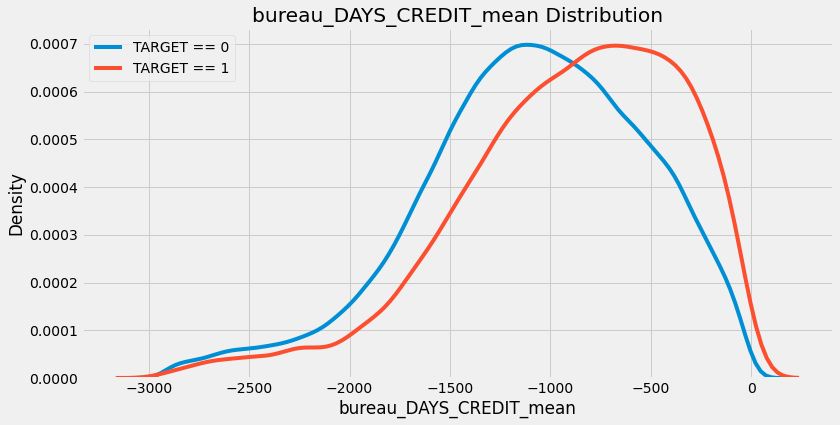

In [17]:
kde_target('bureau_DAYS_CREDIT_mean', train)

The definition of this column is: "How many days before current application did client apply for Credit Bureau credit". My interpretation is this is the number of days that the previous loan was applied for before the application for a loan at Home Credit. Therefore, a larger negative number indicates the loan was further before the current loan application. We see an extremely weak positive relationship between the average of this variable and the target meaning that clients who applied for loans further in the past potentially are more likely to repay loans at Home Credit. With a correlation this weak though, it is just as likely to be noise as a signal.

# Refactoring the aggregation function

In [18]:
# write a function that drop ids, aggregate numeric columns only, then renaming it. 

def agg_numeric(df, group_var, col_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        col_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (col_name, var, stat))

    agg.columns = columns
    return agg

In [19]:
bureau_agg_new = agg_numeric(df = bureau , group_var = 'SK_ID_CURR', col_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [20]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-1572,-49,-5145,7,0.0,0,0,0,7,82.428571,-1329.0,1778.0,577.0,4,-825.500000,-1328.0,-544.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,85500.0,378000.0,1453365.000,7,85240.928571,0.0,373239.0,596686.5,6,0.00000,0.0,0.000,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-155,-6,-652,7,3545.357143,0.0,10822.5,24817.5
1,100002,8,-874.000000,-1437,-103,-6992,8,0.0,0,0,0,6,-349.000000,-1072.0,780.0,-2094.0,6,-697.500000,-1185.0,-36.0,-4185.0,5,1681.029,0.0,5043.645,8405.145,8,0.0,0,0,0,8,108131.945625,0.0,450000.0,865055.565,5,49156.200000,0.0,245781.0,245781.0,4,7997.14125,0.0,31988.565,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-1185,-7,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-2586,-606,-5603,4,0.0,0,0,0,4,-544.500000,-2434.0,1216.0,-2178.0,3,-1097.333333,-2131.0,-540.0,-3292.0,4,0.000,0.0,0.000,0.000,4,0.0,0,0,0,4,254350.125000,22248.0,810000.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,0.0,810000.000,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-2131,-43,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-1326,-408,-1734,2,0.0,0,0,0,2,-488.500000,-595.0,-382.0,-977.0,2,-532.500000,-683.0,-382.0,-1065.0,1,0.000,0.0,0.000,0.000,2,0.0,0,0,0,2,94518.900000,94500.0,94537.8,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.0,0.000,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-682,-382,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-373,-62,-572,3,0.0,0,0,0,3,439.333333,-128.0,1324.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.0,0.000,0.000,3,0.0,0,0,0,3,219042.000000,29826.0,568800.0,657126.000,3,189469.500000,0.0,543087.0,568408.5,3,0.00000,0.0,0.000,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-121,-11,-163,3,1420.500000,0.0,4261.5,4261.5


## Refactor correlation function

In [21]:
# function to calculate correlation between variables and the dependent variable
def target_correlation(df, target):
    
    for col in df:
        # if col == TARGET or the id , drop it
        if col == ('TARGET' or 'SK_ID') in col:
            df_1 = df.drop(columns = col)
            # get the correlation
            temp = df_1.corrwith(df[target])
            # sort by the absolute magniture 
            temp = temp.sort_values(ascending=False)
            
            return temp    

In [22]:
target_correlation(train, 'TARGET')

bureau_DAYS_CREDIT_mean                0.089729
DAYS_BIRTH                             0.078239
bureau_DAYS_CREDIT_min                 0.075248
bureau_DAYS_CREDIT_UPDATE_mean         0.068927
REGION_RATING_CLIENT_W_CITY            0.060893
REGION_RATING_CLIENT                   0.058899
bureau_DAYS_ENDDATE_FACT_min           0.055887
DAYS_LAST_PHONE_CHANGE                 0.055218
bureau_DAYS_CREDIT_ENDDATE_sum         0.053735
bureau_DAYS_ENDDATE_FACT_mean          0.053200
DAYS_ID_PUBLISH                        0.051457
REG_CITY_NOT_WORK_CITY                 0.050994
bureau_DAYS_CREDIT_max                 0.049782
bureau_DAYS_ENDDATE_FACT_sum           0.048854
bureau_DAYS_CREDIT_ENDDATE_mean        0.046983
FLAG_EMP_PHONE                         0.045982
REG_CITY_NOT_LIVE_CITY                 0.044395
FLAG_DOCUMENT_3                        0.044346
bureau_DAYS_CREDIT_UPDATE_min          0.042864
bureau_DAYS_CREDIT_sum                 0.042000
DAYS_REGISTRATION                      0

## Handling categorical variables

I will write a function to pick the categorical variables in a dataframe and create dummy variables for it. Then groupby the given variable name. Finally rename the column with the new value based on the aggregate function.


In [23]:
# write a function to iterate over dataframe and pick the categorical col and dummy it

def process_categorical(df, group_var, col_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    col_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    # pick the categorical column 
    categorical = pd.get_dummies(df.select_dtypes('O'))
    
    # put an id for each column
    categorical[group_var] = df[group_var]
    
    # aggregate the group_var
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    columns_name = []
    
    # iterate over the columns in level 0
    for var in categorical.columns.levels[0]:
        # iterate through level 1 for stats
        for stat in ['count', 'count_norm']:
            # make new column name
            columns_name.append('%s_%s_%s' %(col_name, var, stat))
            
    categorical.columns = columns_name
    
    return categorical

In [24]:
bureau_count = process_categorical(bureau, group_var = 'SK_ID_CURR',col_name = 'bureau')

In [25]:
bureau_count.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


Now, we can process any related data from the tables that has a bureau related data. I will use garbage collector to delete old objects and free up some memory 

In [26]:
# import gc
# gc.enable()

# del train, bureau, bureau_agg, bureau_agg_new, bureau_count

# gc.collect()

In [27]:
# read a new copy of the data

train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')


In [28]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## Stats for bureau dataframe

In [29]:
bureau_counts = process_categorical(df = bureau, group_var = 'SK_ID_CURR', col_name = 'bureau')

bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## Aggreagation for the bureau dataframe

In [30]:
bureau_agg = agg_numeric(df = bureau, group_var = 'SK_ID_CURR', col_name = 'bureau')

In [31]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


## Do the same for bureau_balance

In [32]:
bureau_balance_counts = process_categorical(df = bureau_balance, group_var = 'SK_ID_BUREAU', col_name = 'bureau_balance')

bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [33]:
bureau_balance_agg = agg_numeric(df = bureau_balance, group_var = 'SK_ID_BUREAU', col_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


## Aggregated stats of bureau by client

In [34]:
# dataframe grouped by the loan 
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan.head()


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [35]:
# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,SK_ID_CURR,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5714462,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5714463,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5714464,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5714465,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5714466,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', col_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_count,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_min_count,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_sum,client_bureau_balance_STATUS_0_count_count,client_bureau_balance_STATUS_0_count_mean,client_bureau_balance_STATUS_0_count_max,client_bureau_balance_STATUS_0_count_min,client_bureau_balance_STATUS_0_count_sum,client_bureau_balance_STATUS_0_count_norm_count,client_bureau_balance_STATUS_0_count_norm_mean,client_bureau_balance_STATUS_0_count_norm_max,client_bureau_balance_STATUS_0_count_norm_min,client_bureau_balance_STATUS_0_count_norm_sum,client_bureau_balance_STATUS_1_count_count,client_bureau_balance_STATUS_1_count_mean,client_bureau_balance_STATUS_1_count_max,client_bureau_balance_STATUS_1_count_min,client_bureau_balance_STATUS_1_count_sum,client_bureau_balance_STATUS_1_count_norm_count,client_bureau_balance_STATUS_1_count_norm_mean,client_bureau_balance_STATUS_1_count_norm_max,client_bureau_balance_STATUS_1_count_norm_min,client_bureau_balance_STATUS_1_count_norm_sum,client_bureau_balance_STATUS_2_count_count,client_bureau_balance_STATUS_2_count_mean,client_bureau_balance_STATUS_2_count_max,client_bureau_balance_STATUS_2_count_min,client_bureau_balance_STATUS_2_count_sum,client_bureau_balance_STATUS_2_count_norm_count,client_bureau_balance_STATUS_2_count_norm_mean,client_bureau_balance_STATUS_2_count_norm_max,client_bureau_balance_STATUS_2_count_norm_min,client_bureau_balance_STATUS_2_count_norm_sum,client_bureau_balance_STATUS_3_count_count,client_bureau_balance_STATUS_3_count_mean,client_bureau_balance_STATUS_3_count_max,client_bureau_balance_STATUS_3_count_min,client_bureau_balance_STATUS_3_count_sum,client_bureau_balance_STATUS_3_count_norm_count,client_bureau_balance_STATUS_3_count_norm_mean,client_bureau_balance_STATUS_3_count_norm_max,client_bureau_balance_STATUS_3_count_norm_min,client_bureau_balance_STATUS_3_count_norm_sum,client_bureau_balance_STATUS_4_count_count,client_bureau_balance_STATUS_4_count_mean,client_bureau_balance_STATUS_4_count_max,client_bureau_balance_STATUS_4_count_min,client_bureau_balance_STATUS_4_count_sum,client_bureau_balance_STATUS_4_count_norm_count,client_bureau_balance_STATUS_4_count_norm_mean,client_bureau_balance_STATUS_4_count_norm_max,client_bureau_balance_STATUS_4_count_norm_min,client_bureau_balance_STATUS_4_count_norm_sum,client_bureau_balance_STATUS_5_count_count,client_bureau_balance_STATUS_5_count_mean,client_bureau_balance_STATUS_5_count_max,client_bureau_balance_STATUS_5_count_min,client_bureau_balance_STATUS_5_count_sum,client_bureau_balance_STATUS_5_count_norm_count,client_bureau_balance_STATUS_5_count_norm_mean,client_bureau_balance_STATUS_5_count_norm_max,client_bureau_balance_STATUS_5_count_norm_min,client_bureau_balance_STATUS_5_count_norm_sum,client_bureau_balance_STATUS_C_count_count,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_max,client_bureau_balance_STATUS_C_count_min,client_bureau_balanc

## Merge into training data

In [37]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [38]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [39]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


## Missing values

In [40]:
# Function to calculate missing values by column# Funct 
def missing_percent(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_table = pd.concat([mis_val, mis_percent], axis=1)
        
        # Rename the columns
        mis_columns = mis_table.rename(
        columns = {0 : 'Missing Values', 1 : 'Percent of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_columns = mis_columns[
            mis_columns.iloc[:,1] != 0].sort_values(
        'Percent of Total Values', ascending=False).round(2)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_columns

In [41]:
train_missing = missing_percent(train)
train_missing.head()

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,Percent of Total Values
bureau_AMT_ANNUITY_min,227502,73.98
bureau_AMT_ANNUITY_max,227502,73.98
bureau_AMT_ANNUITY_mean,227502,73.98
client_bureau_balance_STATUS_4_count_min,215280,70.01
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.01


There are a quite number of columns that have a plenty of missing data. I am going to drop any column that have missing data than 90%.

In [42]:
missing_vars_train = train_missing.loc[train_missing['Percent of Total Values'] > 90, 'Percent of Total Values']
len(missing_vars_train)

0

## Calculate missing data for the test data

In [43]:
# Read in the test dataframe
test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [44]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


We need to align `train` and `test` to make sure that they have the same columns 

In [45]:
# create a train target label 
train_label = train['TARGET']

# align both dataframes, this will remove TARGET column
train, test = train.align(test, join='inner', axis = 1)

train['TARGET'] = train_label

In [46]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


Now they have the same number of columns, we can now check the missing data in the test data

In [47]:
test_missing = missing_percent(test)
test_missing.head()

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,Percent of Total Values
COMMONAREA_MEDI,33495,68.72
COMMONAREA_MODE,33495,68.72
COMMONAREA_AVG,33495,68.72
NONLIVINGAPARTMENTS_MEDI,33347,68.41
NONLIVINGAPARTMENTS_AVG,33347,68.41


In [48]:
missing_vars_test = test_missing.loc[test_missing['Percent of Total Values'] > 90, 'Percent of Total Values']
len(missing_vars_test)

0

In [49]:
missing_columns = set(missing_vars_test + missing_vars_train)
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [50]:
train.to_csv('train_bureau_raw.csv', index=False)
test.to_csv('test_bureau_raw.csv', index=False)

## Correlation 


In [51]:
# calculate correlation for all dataframes
corr_train = train.corr()

In [52]:
corr_train = corr_train.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corr_train['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


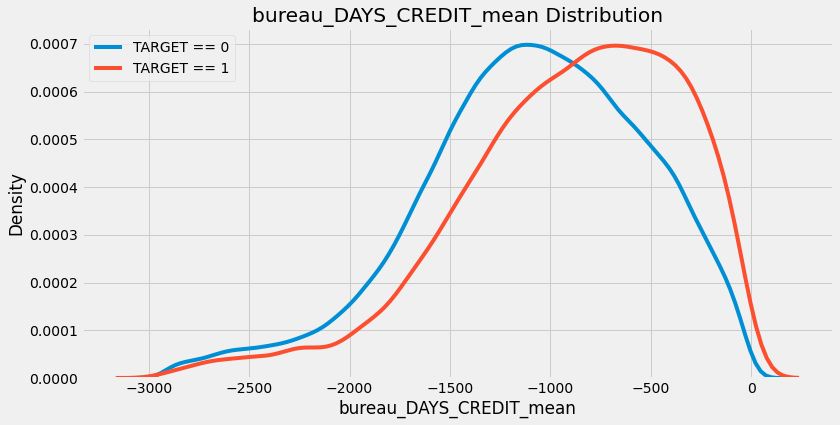

In [53]:
kde_target('bureau_DAYS_CREDIT_mean', train)

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.3636


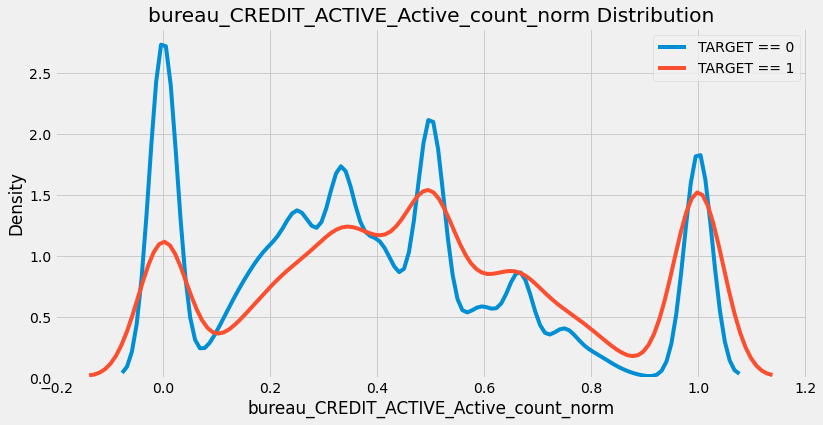

In [54]:
kde_target('bureau_CREDIT_ACTIVE_Active_count_norm', train)

## Collinear Variables
We can calculate not only the correlations of the variables with the target, but also the correlation of each variable with every other variable. This will allow us to see if there are highly collinear variables that should perhaps be removed from the data.

In [55]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr_train:
    above_threshold_vars[col] = list(corr_train.index[corr_train[col] > threshold])

For each of these pairs of highly correlated variables, we only want to remove one of the variables. The following code creates a set of variables to remove by only adding one of each pair.

In [56]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


We can remove these columns from both the training and the testing datasets. We will have to compare performance after removing these variables with performance keeping these variables (the raw csv files we saved earlier).

In [57]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [58]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

## Modeling


In [59]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

To actually test the performance of these new datasets, we will try using them for machine learning! Here we will use a function I developed in another notebook to compare the features (the raw version with the highly correlated variables removed). We can run this kind of like an experiment, and the control will be the performance of just the application data in this function when submitted to the competition. I've already recorded that performance, so we can list out our control and our two test conditions:

* control: only the data in the application files.
* test one: the data in the application files with all of the data recorded from the bureau and bureau_balance files
* test two: the data in the application files with all of the data recorded from the bureau and bureau_balance files with highly correlated variables removed.

In [60]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
            """
        # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [61]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

## Control
The first step in any experiment is establishing a control. For this we will use the function defined above (that implements a Gradient Boosting Machine model) and the single main data source (application).

In [62]:
train_control = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
test_control = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

In [ ]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798103	train's binary_logloss: 0.548552	valid's auc: 0.760007	valid's binary_logloss: 0.561913
Early stopping, best iteration is:
[269]	train's auc: 0.809199	train's binary_logloss: 0.537755	valid's auc: 0.760273	valid's binary_logloss: 0.555207
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798328	train's binary_logloss: 0.54852	valid's auc: 0.76114	valid's binary_logloss: 0.566651
Early stopping, best iteration is:
[289]	train's auc: 0.812654	train's binary_logloss: 0.534422	valid's auc: 0.761398	valid's binary_logloss: 0.558103
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.79964	train's binary_logloss: 0.54685	valid's auc: 0.750232	valid's binary_logloss: 0.564639
Early stopping, best iteration is:
[265]	train's auc: 0.809734	train's binary_logloss: 0.53678	val

In [ ]:
metrics

The control slightly overfits because the training score is higher than the validation score. 

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('control.csv', index = False)